In [1]:
# Optional: setup NoTexBook theme
%load_ext notexbook
%texify -fs 18

# Differential Privacy

Like $k$-Anonymity, *differential privacy*[3](#fn3) is a **formal notion of privacy** 
(i.e. it's possible to prove that a data release has the property). 

Unlike $k$-Anonymity, however, **differential privacy** is a property of *algorithms*, and not a property of *data*. 

That is, we can prove a *dataset* satisfies differential privacy by proving that an *algorithm* satisfies differential privacy.

> **Definition**:
>
> A function which satisfies differential privacy is often called a *mechanism*. 
> We say that a *mechanism* $F$ satisfies differential privacy if for all *neighboring datasets* $x$ and $x'$, 
> and all possible outputs $S$,
>

\begin{equation}
\frac{\mathsf{Pr}[F(x) = S]}{\mathsf{Pr}[F(x') = S]} \leq e^\epsilon
\end{equation}

**1. Neighbours Datasets**:

Two datasets are considered **neighbours** if they differ in the data by **one single individual**.

**2. $F$ Randomised Function**:

Note that $F$ is typically a *randomised* function, so that the probability distribution describing its outputs is not just a point distribution.

The important implication of this definition is that $F$'s output will be pretty much the same, *with or without* the data of any specific individual.

In other words, the randomness built into $F$ should be "enough" so that an observed output from $F$ will not reveal which of $x$ or $x'$ was the input.

Imagine that my data is present in $x$ but not in $x'$.

**3. The Privacy Budget: $\epsilon$**

If an adversary can't determine which of $x$ or $x'$ was the input to $F$, then the adversary can't tell whether or not my data was *present* in the input - let alone the contents of that data.

The $\epsilon$ parameter in the definition is called the *privacy parameter* or the *privacy budget*.

$\epsilon$ provides a knob to tune the **amount of privacy** the definition provides.

Small values of $\epsilon$ require $F$ to provide *very* similar outputs when given similar inputs, and therefore provide **higher levels** of privacy.

Large values of $\epsilon$ allow less similarity in the outputs, and therefore provide **less privacy**.


- Small values $\epsilon \rightarrow$ High Privacy
- Large values $\epsilon \rightarrow$ Less Privacy

How should we set $\epsilon$ to prevent bad outcomes in practice? **Nobody knows** (i.e. Open Research Question). 

The general consensus is that $\epsilon$ should be around `1` or smaller, and values of $\epsilon$ above `10` probably don't do much to protect privacy - but this rule of thumb could turn out to be very conservative. 

<span id="fn3">**[3]**: Dwork, C; _Differential Privacy_ in Proceedings of the 33rd International Conference on Automata, Languages and Programming - Volume Part II, 2006 [link](https://doi.org/10.1007/11787006_1)</span>

## The Laplace Mechanism

Differential privacy is typically used to answer specific queries. Let's consider a query on the census data, *without* differential privacy.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
DATASET_URL = "https://raw.githubusercontent.com/uvm-plaid/programming-dp/master/notebooks/adult_with_pii.csv"
adult = pd.read_csv(DATASET_URL)

**Q** "How many individuals in the dataset are 40 years old or older?"

This is an example of a **Count Query**.

In [4]:
adult.head()

,Name,DOB,SSN,Zip,Workclass,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age,Capital Gain,Capital Loss
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K,56,2174,0
1,Brandise Tripony,6/7/1988,150-19-2766,61523,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K,35,0,0
2,Brenn McNeely,8/6/1991,725-59-9860,95668,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K,32,0,0
3,Dorry Poter,4/6/2009,659-57-4974,25503,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K,14,0,0
4,Dick Honnan,9/16/1951,220-93-3811,75387,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K,72,0,0


In [5]:
adult.query('Age >= 40').shape[0]

17449

## Laplace Mechanism

The easiest way to achieve differential privacy for this query is to add **random noise to its answer**. 

The key challenge is to add enough noise to satisfy the definition of differential privacy, but not so much that the answer becomes too noisy to be useful. 

To make this process easier, some basic *mechanisms* have been developed in the field of differential privacy, which describe exactly what kind of - and how much - noise to use. 

One of these is called the *Laplace mechanism*[4](#fn4).

> **Definition**
> 
>According to the Laplace mechanism, for a function $f(x)$ which returns a number, the following definition of $F(x)$ satisfies $\epsilon$-differential privacy:
>
>\begin{equation}
F(x) = f(x) + \textsf{Lap}(\frac{s}{\epsilon})
\end{equation}
>
>where $s$ is the *sensitivity* of $f$, and $\textsf{Lap}(S)$ denotes sampling from the Laplace distribution with center 0 and scale $S$.


**Sensitivity**:

The *sensitivity* of a function $f$ is the amount $f$'s output changes when its input changes by 1. 

Sensitivity is a complex topic, and an integral part of designing differentially private algorithms. 

Let's just point out that *counting queries* always have a sensitivity of `1`: if a query counts the number of rows in the dataset with a particular property, and then we modify exactly one row of the dataset, then the query's output can change by at most `1`.

Thus we can achieve differential privacy for our example query by using the `Laplace mechanism` with `sensitivity=1` and an $\epsilon$ of our choosing.

For now, let's pick $\epsilon = 0.1$. We can sample from the Laplace distribution using Numpy's `random.laplace`.

<span id="fn4">**[4]**: Dwork, C.; _Calibrating Noise to Sensitivity in Private Data Analysis_ in Proceedings of the Third Conference on Theory of Cryptography, 2006 [link](https://doi.org/10.1007/11681878_14)</span>

In [6]:
sensitivity = 1
epsilon = 0.1

adult.query("Age >= 40").shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)

17433.26218243701

You can see the effect of the noise by running this code multiple times. Each time, the output changes, but most of the time, the answer is close enough to the true answer to be useful.

In [7]:
true_count_stat = adult[adult['Age'] >= 40].shape[0]
Lap = np.random.laplace(loc=0, scale=sensitivity/epsilon, size=30)
print(f"True Count Statistic: {true_count_stat}")
for i in range(30):
    print(f"{i}) {(true_count_stat + Lap[i]):0.2f}")

True Count Statistic: 17449
0) 17441.62
1) 17486.77
2) 17425.54
3) 17455.44
4) 17451.13
5) 17447.01
6) 17452.67
7) 17439.52
8) 17428.14
9) 17452.67
10) 17406.58
11) 17477.19
12) 17463.48
13) 17454.53
14) 17482.74
15) 17439.95
16) 17457.63
17) 17460.08
18) 17437.32
19) 17448.83
20) 17438.86
21) 17439.23
22) 17456.50
23) 17442.26
24) 17446.23
25) 17448.95
26) 17452.35
27) 17442.58
28) 17467.10
29) 17510.63


In [8]:
np.mean([true_count_stat + l for l in Lap])

17451.785133490783

## How Much Noise is Enough?

How do we know that the Laplace mechanism adds enough noise to prevent the re-identification of individuals in the dataset? 

For one thing, we can try to break it!

Let's write down a **malicious counting query**, which is specifically designed to determine whether Karrie Trusslove has an income greater than `$50k`.

In [9]:
karries_row = adult[adult['Name'] == 'Karrie Trusslove']
karries_row[karries_row['Target'] == '<=50K'].shape[0]

1

This result definitely violates Karrie's privacy, since it reveals the value of the income column for Karrie's row.

Since we know how to ensure differential privacy for counting queries with the Laplace mechanism, we can do so for this query:

In [10]:
sensitivity = 1
epsilon = 0.1

karries_row = adult[adult['Name'] == 'Karrie Trusslove']
karries_row[karries_row['Target'] == '<=50K'].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)

-8.565155687857445

In [11]:
query = karries_row[karries_row['Target'] == '<=50K'].shape[0]

In [12]:
F = query + np.random.laplace(loc=0, scale=sensitivity/epsilon)

np.mean([F for _ in range(100)])

4.545149052398201

Is this the true answer ?

There's too much noise to be able to reliably tell.

This is how differential privacy is *intended* to work - the approach does not *reject* queries which are determined to be malicious; instead, it adds enough noise that the results of a malicious query will be useless to the adversary.

---

# Properties of Differential Privacy

In this notebook we will mention three important properties of **differentially private mechanisms** that arise from the definition
 of differential privacy.

These properties are mentioned as they will be used / referenced when we will start generalising DP applications 
to Machine Learning algorithms.


These three properties are:

1. Sequential composition
2. Parallel composition
3. Post processing

## Sequential Composition

The first major property of differential privacy is *sequential composition*, which **bounds** the total 
privacy cost of releasing multiple results of differentially private mechanisms **on the same input data**. 

Formally, the sequential composition theorem for differential privacy says that:

- If $F_1(x)$ satisfies $\epsilon_1$-differential privacy
- And $F_2(x)$ satisfies $\epsilon_2$-differential privacy
- Then the mechanism $G(x) = (F_1(x), F_2(x))$ which releases both results satisfies $\epsilon_1+\epsilon_2$-differential privacy


Sequential composition is a vital property of differential privacy because it enables the design of algorithms that consult the data more than once. 

Sequential composition is also important when multiple separate analyses are performed on a single dataset, since it allows individuals to bound the *total* privacy cost they incur by participating in all of these analyses.

The bound on privacy cost given by sequential composition is an *upper* bound - the actual privacy cost of two particular differentially private releases may be smaller than this, but never larger.

The principle that the $\epsilon$-s "add up" makes sense if we examine the distribution of outputs from a mechanism which averages two differentially private results together.

However, please bear in mind that Sequential composition does not provide an **exact** upper bound: the exact total privacy cost can be indeed lower than the upper bound!.

## Parallel Composition

The second important property of differential privacy is called *parallel composition*. 

Parallel composition can be seen as an alternative to sequential composition - a second way to calculate a bound on the total privacy cost of multiple data releases. 

Parallel composition is based on the idea of **splitting** your dataset into disjoint chunks and running a 
differentially private mechanism on each chunk separately. 

Since the chunks are **disjoint**, each individual's data appears in *exactly* one chunk - so even if there are $k$ chunks in total (and therefore $k$ runs of the mechanism), the mechanism runs exactly once on the data of each *individual*. 

Formally,
 - If $F(x)$ satisfies $\epsilon$-differential privacy
 - And we split a dataset $X$ into $k$ disjoint chunks such that $x_1 \cup ... \cup x_k = X$
 - Then the mechanism which releases all of the results $F(x_1), ..., F(x_k)$ satisfies $\epsilon$-differential privacy

Note that this is a much better bound than sequential composition would give. 

Since we run $F$ $k$ times, sequential composition would say that this procedure satisfies $k\epsilon$-differential privacy. 

Parallel composition allows us to say that the total privacy cost is just $\epsilon$.

The formal definition matches up with our intuition - if each participant in the dataset contributes one row to $X$, then this row will appear in *exactly* one of the chunks $x_1, ..., x_k$. 

That means $F$ will only "see" this participant's data *one time*, meaning a privacy cost of $\epsilon$ is appropriate for that individual. Since this property holds for all individuals, the privacy cost is $\epsilon$ for everyone.

## Post-processing

The third property of differential privacy is called *post-processing*. 

The idea is simple: it's impossible to **reverse the privacy protection** provided by differential privacy by post-processing the data in some way. 

Formally:

- If $F(X)$ satisfies $\epsilon$-differential privacy
- Then for any (deterministic or randomized) function $g$, $g(F(X))$ satisfies $\epsilon$-differential privacy

The post-processing property means that it's always safe to perform arbitrary computations on the output of a differentially private mechanism - there's no danger of reversing the privacy protection the mechanism has provided. 

In particular, it's fine to perform post-processing that might reduce the noise or improve the signal in the mechanism's output (e.g. replacing negative results with zeros, for queries that shouldn't return negative results). 

The other implication of the **post-processing** property is that differential privacy provides resistance against privacy attacks based on **auxiliary information**. 

For example, the function $g$ might contain auxiliary information about elements of the dataset, and attempt to perform a linkage attack using this information. The post-processing property says that such an attack is limited in its effectiveness by the privacy parameter $\epsilon$, regardless of the auxiliary information contained in $g$.

---

### Histograms

In our context, a *histogram* is an analysis of a dataset which splits the dataset into "bins" based on the value of one of the data attributes, and **counts** the number of rows in each bin. 

For example, a histogram might count the number of people in the dataset who achieved a particular educational level.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

In [14]:
DATASET_URL = "https://raw.githubusercontent.com/uvm-plaid/programming-dp/master/notebooks/adult_with_pii.csv"
adult = pd.read_csv(DATASET_URL)

adult['Education'].value_counts().to_frame().head(5)

,Education
HS-grad,10501
Some-college,7291
Bachelors,5355
Masters,1723
Assoc-voc,1382


Histograms are particularly interesting for differential privacy because they automatically satisfy parallel composition. 

Each "bin" in a histogram is defined by a possible value for a data attribute (for example, `'Education' == 'HS-grad'`). 

It's impossible for a single row to have *two* values for an attribute simultaneously, so defining the bins this way *guarantees* that they will be disjoint. 

Thus we have satisfied the requirements for parallel composition, and we can use a differentially private mechanism to release *all* 
of the bin counts with a total privacy cost of just $\epsilon$.

In [15]:
epsilon = 1
sensitivity = 1

# This analysis has a total privacy cost of epsilon = 1, even though we release many results!
f = lambda x: x + np.random.laplace(loc=0, scale=sensitivity/epsilon)
s = adult['Education'].value_counts().apply(f)
s.to_frame().head(5)

,Education
HS-grad,10500.985614
Some-college,7290.295353
Bachelors,5355.129608
Masters,1724.890606
Assoc-voc,1383.383950


## Sensitivity

When discussing the Laplace mechanism, we mentioned that the amount of **noise** that is necessary to ensure differential privacy for 
a given query depends on the *sensitivity* of the query. 

Roughly speaking, the **sensitivity of a function reflects the amount the function's output will change when its input changes**. 

Recall that the Laplace mechanism defines a mechanism $F(x)$ as follows:

\begin{align}
F(x) = f(x) + \textsf{Lap}\left(\frac{s}{\epsilon}\right)
\end{align}

where $f(x)$ is a deterministic function (the query), $\epsilon$ is the privacy parameter, and $s$ is the sensitivity of $f$.

For a function $f : \mathbb{D} \rightarrow \mathbb{R}$ mapping datasets ($\mathbb{D}$) to real numbers, the *global sensitivity* of $f$ is defined as follows:

\begin{align}
GS(f) = \max_{x, x': d(x,x') <= 1} |f(x) - f(x')|
\end{align}

Here, $d(x, x')$ represents the *distance* between two datasets $x$ and $x'$, and we say that two datasets are *neighbors* if their distance is 1 or less. 

How this distance is defined has a huge effect on the definition of privacy we obtain.

The definition of global sensitivity says that for *any two* neighboring datasets $x$ and $x'$, the difference between $f(x)$ and $f(x')$ is at most $GS(f)$. 

**Global vs Local Sensitivity**:

This measure of sensitivity is called "global" because it is independent of the actual dataset being queried (it holds for *any* choice of neighboring $x$ and $x'$). 

Another measure of sensitivity, called *local sensitivity*, fixes one of the datasets to be the one being queried.

## Distance

The distance metric $d(x,x')$ described earlier can be defined in many different ways. 

Intuitively, the distance between two datasets should be equal to 1 (i.e. the datasets are neighbors) if they differ in the data of exactly **one individual**. 

This idea is easy to formalize in some contexts (e.g. in the US Census, each individual submits a single response containing their data) but extremely challenging in others (e.g. location trajectories, social networks, and time-series data).

A common formal definition for datasets containing rows is to consider the number of rows which differ between the two. 

When each individual's data is contained in a single row, this definition often makes sense. 

Formally, this definition of distance is encoded as a **symmetric difference** between the two datasets:

\begin{align}
d(x, x') = | x - x' \cup x' - x |
\end{align}

This particular definition has several interesting and important implications:
- If $x'$ is constructed from $x$ by *adding one row*, then $d(x,x') = 1$
- If $x'$ is constructed from $x$ by *removing one row*, then $d(x,x') = 1$
- If $x'$ is constructed from $x$ by *modifying one row*, then $d(x,x') = 2$

In other words, adding or removing a row results in a neighboring dataset; *modifying* a row results in a dataset at distance *2*. 

This particular definition of distance results in what is typically called *unbounded differential privacy*. Many other definitions are possible, including one called **bounded differential privacy** in which modifying a single row in a dataset *does* result in a neighboring dataset. 


### Calculating Sensitivity

How do we determine the sensitivity of a particular function of interest? For some simple functions on real numbers, the answer is obvious.

- The global sensitivity of $f(x) = x$ is 1, since changing $x$ by 1 changes $f(x)$ by 1
- The global sensitivity of $f(x) = x+x$ is 2, since changing $x$ by 1 changes $f(x)$ by 2
- The global sensitivity of $f(x) = 5*x$ is 5, since changing $x$ by 1 changes $f(x)$ by 5
- The global sensitivity of $f(x) = x*x$ is unbounded, since the change in $f(x)$ depends on the value of $x$

For functions that map datasets to real numbers, we can perform a similar analysis. We will consider the functions which represent common aggregate database queries: counts, sums, and averages.

#### Counting Queries

Counting queries (`COUNT` in SQL) count the number of rows in the dataset which satisfy a specific property. 

As a rule of thumb, **counting queries always have a sensitivity of 1**. 

This is because adding a row to the dataset can increase the output of the query by at most 1: either the new row has the desired property, and the count increases by 1, or it does not, and the count stays the same (the count may correspondingly decrease when a row is removed).

**Example: "How many people are in the dataset?"** (sensitivity: 1 - counting rows where the property = True)

In [16]:
adult.shape[0]

32561

**Example: "How many people have an educational status above 10?"** (sensitivity: 1 - counting rows with a property)

In [17]:
adult[adult['Education-Num'] > 10].shape[0]

10516

In [18]:
adult[adult['Name'] == 'Joe Near'].shape[0]

0

#### Summation Queries

Summation queries (`SUM` in SQL) sum up the *attribute values* of dataset rows.

**Example: "What is the sum of the ages of people with an educational status above 10?"**

In [19]:
adult[adult['Education-Num'] > 10]['Age'].sum()

441338

Sensitivity for these queries is not **as simple as it is for counting queries**. 

Adding a new row to the dataset will increase the result of our example query by the *age of the new person*. 

That means the sensitivity of the query depends on the **contents** of the row we add.

As a rule of thumb, summation queries have **unbounded sensitivity** when no lower and upper bounds exist on the value of the attribute being summed. 

When lower and upper bounds do exist, the sensitivity of a summation query is equal to the **difference between them**. 

In the next section, we will see a technique called **clipping** for enforcing bounds when none exist, so that summation queries with unbounded sensitivity can be converted into queries with bounded sensitivity.

#### Average Queries

Average queries (`AVG` in SQL) calculate the mean of attribute values in a particular column.

**Example: "What is the average age of people with an educational status above 10?"**

In [20]:
adult[adult['Education-Num'] > 10]['Age'].mean()

41.96823887409661

The easiest way to answer an average query with differential privacy is by re-phrasing it as two queries: a summation query divided by a counting query. For the above example:

In [21]:
adult[adult['Education-Num'] > 10]['Age'].sum() / adult[adult['Education-Num'] > 10]['Age'].shape[0]

41.96823887409661

The sensitivities of both queries can be calculated as described above. 

Noisy answers for each can be calculated (e.g. using the Laplace mechanism) and the noisy answers can be divided to obtain a differentially private mean. 

The total privacy cost of both queries can be calculated by **sequential composition**.

## Clipping

Queries with unbounded sensitivity cannot be directly answered with differential privacy using the Laplace mechanism. 

Fortunately, we can often transform such queries into equivalent queries with *bounded* sensitivity, via a process called **clipping**.

The basic idea behind clipping is to **enforce** upper and lower bounds on attribute values. 

> For example, ages above 125 can be "clipped" to exactly 125. 

After clipping has been performed, we are **guaranteed** that all ages will be 125 or below. 

As a result, the sensitivity of a summation query on clipped data is equal to the difference between the upper and lower bounds used in clipping: $upper - lower$. 

For example, the following query has a sensitivity of 125:

In [22]:
adult['Age'].clip(lower=0, upper=125).sum()

1360144

The primary challenge in performing clipping is to determine the **upper** and **lower** bounds. 

Furthermore, there is a tradeoff between the amount of information lost in clipping and the amount of noise needed to ensure differential privacy. 

As a rule of thumb, **try to set the clipping bounds to include 100% of the dataset**, or get as close as possible. This is harder in some domains (e.g. graph queries) than others.

It's tempting to determine the clipping bounds by looking at the data. For example, we can look at the histogram of ages in our dataset to determine an appropriate upper bound:

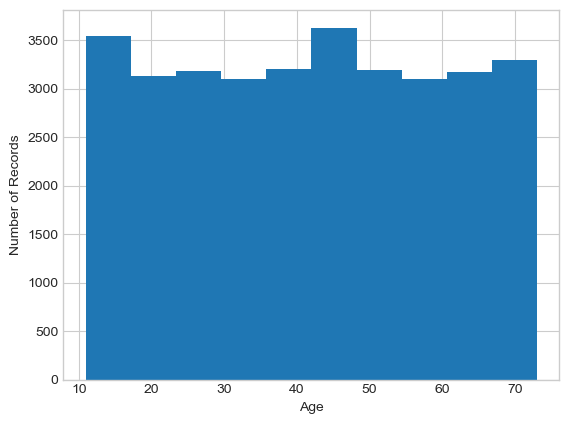

In [23]:
plt.hist(adult['Age'])
plt.xlabel('Age')
plt.ylabel('Number of Records');

It's clear from this histogram that nobody in this particular dataset is over 90, so an upper bound of 90 would suffice.

**NOTE**: However, it's important to note that **this approach does not satisfy differential privacy**. 

If we pick our clipping bounds by looking at the data, then the bounds themselves might reveal something about the data.

Typically, clipping bounds are decided either by using a property of the dataset that can be known without looking at the data (e.g. that the dataset contains ages, which are likely to lie between 0 and 125), or by performing **differentially private queries** to evaluate different choices for the clipping bounds.

**Determine Upper bound with differentially private queries**:

To use the second approach, we typically set the lower bound to 0 and slowly increase the upper bound until the query's output stops changing (meaning we haven't included any new data by increasing the bound). 

For example, let's try computing the sum of ages for clipping bounds `from 0 to 100``, using the Laplace mechanism for each one to ensure differential privacy:

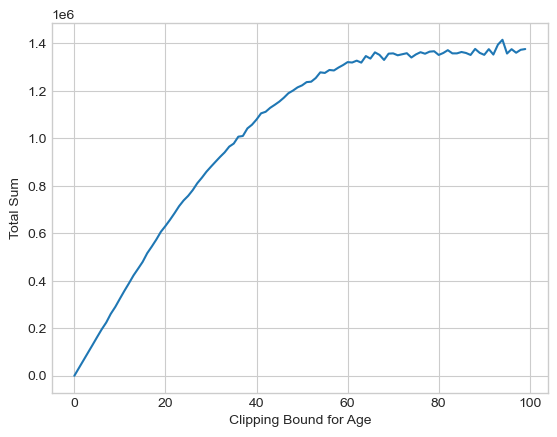

In [24]:
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity/epsilon)

epsilon_i = .01
plt.plot([laplace_mech(adult['Age'].clip(lower=0, upper=i).sum(), i, epsilon_i) for i in range(100)])
plt.xlabel('Clipping Bound for Age')
plt.ylabel('Total Sum');

The total privacy cost for building this plot is $\epsilon = 1$ by sequential composition, since we do 100 queries each with $\epsilon_i = 0.01$. It's clear that the results level off around a value of `upper = 80`, so this is a good choice for the clipping bound.

One refinement that **can work well when the scale of the data is not known** is to test upper bounds according to a logarithmic scale.

---

# Approximate Differential Privacy


Approximate differential privacy, also called $(\epsilon, \delta)$-differential privacy, has the following definition:

\begin{align}
\mathsf{Pr}[F(x) = S] \leq e^\epsilon \mathsf{Pr}[F(x') = s] + \delta
\end{align}

The new privacy parameter, $\delta$, represents a "failure probability" for the definition. 

With probability $1-\delta$, we will get the same guarantee as pure differential privacy; with probability $\delta$, we get no guarantee. 

In other words:

- With probability $1-\delta$, $\frac{\mathsf{Pr}[F(x) = S]}{\mathsf{Pr}[F(x') = s]} \leq e^\epsilon$
- With probability $\delta$, we get no guarantee at all

This definition should seem a little bit scary! 

With probability $\delta$, anything at all could happen - including a release of the entire sensitive dataset! 

For this reason, we typically require $\delta$ to be very small - usually $\frac{1}{n^2}$ or less, where $n$ is the size of the dataset. 

In addition, it can be demonstrated in practice that the $(\epsilon, \delta)$-differentially private mechanisms in practical use 
don't fail catastrophically - as allowed by the definition - instead, they fail *gracefully*, and don't do terrible things like 
releasing the entire dataset.


Such mechanisms *are* possible, however, and they do satisfy the definition of $(\epsilon, \delta)$-differential privacy.

## Properties of Approximate Differential Privacy

Approximate differential privacy has similar properties to pure $\epsilon$-differential privacy. It satisfies **sequential composition**:

- If $F_1(x)$ satisfies $(\epsilon_1, \delta_1)$-differential privacy
- And $F_2(x)$ satisfies $(\epsilon_2, \delta_2)$-differential privacy
- Then the mechanism $G(x) = (F_1(x), F_2(x))$ which releases both results satisfies $(\epsilon_1+\epsilon_2, \delta_1 + \delta_2)$-differential privacy

The only difference from the pure $\epsilon$ setting is that we add up the values of $\delta$ as well as the values of $\epsilon$. 

Approximate differential privacy also satisfies **post-processing and parallel composition**.

## The Gaussian Mechanism

The Gaussian mechanism is an alternative to the Laplace mechanism, which adds Gaussian noise instead of Laplacian noise. 

The Gaussian mechanism does *not* satisfy pure $\epsilon$-differential privacy, but does satisfy $(\epsilon, \delta)$-differential 
privacy.

According to the Gaussian mechanism, for a function $f(x)$ which returns a number, the following definition of $F(x)$ satisfies $(\epsilon, \delta)$-differential privacy:

\begin{align}
F(x) = f(x) + \mathcal{N}(\sigma^2)\\
\text{where } \sigma^2 = \frac{2s^2 \log(1.25/\delta)}{\epsilon^2}
\end{align}

where $s$ is the sensitivity of $f$, and $\mathcal{N}(\sigma^2)$ denotes sampling from the Gaussian (normal) distribution with center 0 and variance $\sigma^2$. Note that here (and elsewhere in these notes), $\log$ denotes the natural logarithm.

For real-valued functions $f : D \rightarrow \mathbb{R}$, we can use the Gaussian mechanism in exactly the same way as we do the Laplace mechanism, and it's easy to compare what happens under both mechanisms for a given value of $\epsilon$.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

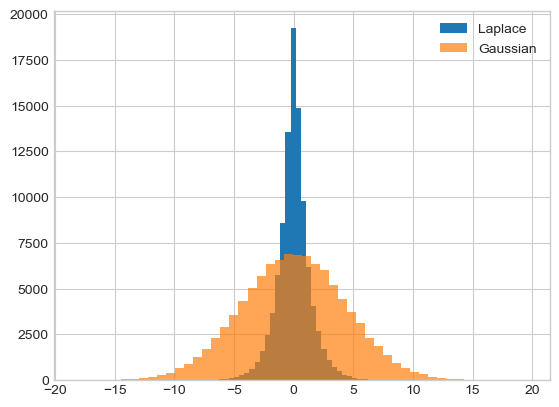

In [3]:
epsilon = 1
vals_laplace = [np.random.laplace(loc=0, scale=1/epsilon) for x in range(100000)]

delta = 10e-5
sigma = np.sqrt(2 * np.log(1.25 / delta)) * 1 / epsilon
vals_gauss = [np.random.normal(loc=0, scale=sigma) for x in range(100000)]

plt.hist(vals_laplace, bins=50, label='Laplace')
plt.hist(vals_gauss, bins=50, alpha=.7, label='Gaussian');
plt.legend();

Here, we graph the empirical probability density function of the Laplace and Gaussian mechanisms for $\epsilon = 1$, with $\delta = 10^{-5}$ for the Gaussian mechanism.

Compared to the Laplace mechanism, the plot for the Gaussian mechanism looks "squished." 

Differentially private outputs which are far from the true answer are much more likely using the Gaussian mechanism than they are under the Laplace mechanism (which, by comparison, looks extremely "pointy").

So the Gaussian mechanism has two **major drawbacks**:

1. it requires the use of the the relaxed $(\epsilon, \delta)$-differential privacy definition, *and* 
2. it's less accurate than the Laplace mechanism. 

Why would we want to use it?

## Vector-Valued Functions and their Sensitivities

So far, we have only considered real-valued functions (i.e. the function's output is always a single real number). 

Such functions are of the form $f : D \rightarrow \mathbb{R}$. 

Both the Laplace and Gaussian mechanism, however, can be extended to *vector-valued* functions of the form $f : D \rightarrow \mathbb{R}^k$, which return vectors of real numbers. 

We can think of histograms as vector-valued functions, which return a vector whose elements consist of histogram bin counts.

We saw earlier that the *sensitivity* of a function is:

\begin{align}
GS(f) = \max_{d(x,x') \leq 1} \lvert f(x) - f(x') \rvert
\end{align}

How do we define sensitivity for vector-valued functions?

Consider the expression $f(x) - f(x')$. 

If $f$ is a vector-valued function, then this expression represents the difference between two vectors, which can be computed as the difference between their corresponding elements (the difference of two length-$k$ vectors is thus a new length-$k$ vector). 

This new vector is the distance between $f(x)$ and $f(x')$, represented as a vector.

The magnitude of this vector is the sensitivity of $f$. 

There are several ways to compute the magnitude of a vector; we'll use two of them: the $L1$ norm and the $L2$ norm.

### L1 and L2 Norms

The $L1$ norm of a vector $V$ of length $k$ is defined as $\lVert V \rVert_1 = \sum_{i=1}^k \lvert V_i \rvert$ (i.e. it's the sum of the vector's elements). In 2-dimensional space, the $L1$ norm of the difference between two vectors yields the "manhattan distance" between them.

The $L2$ norm of a vector $V$ of length $k$ is defined as $\lVert V \rVert_2 = \sqrt{\sum_{i=1}^k V_i^2}$ (i.e. the square root of the sum of the squares). In 2-dimensional space, this is the "Euclidean distance", and it's always less than or equal to the $L1$ norm.

### L1 and L2 Sensitivities

The $L1$ sensitivity of a vector-valued function $f$ is:

\begin{align}
GS(f) = \max_{d(x,x') \leq 1} \lVert f(x) - f(x') \rVert_1
\end{align}

This is equal to the sum of the *elementwise* sensitivities. For example, if we define a vector-valued function $f$ that returns a length-$k$ vector of 1-sensitive results, then the $L1$ sensitivity of $f$ is $k$.

Similarly, the $L2$ sensitivity of a vector-valued function $f$ is:

\begin{align}
GS_2(f) = \max_{d(x,x') \leq 1} \lVert f(x) - f(x') \rVert_2
\end{align}

Using the same example as above, a vector-valued function $f$ returning a length-$k$ vector of 1-sensitive results has $L2$ sensitivity of $\sqrt{k}$. For long vectors, the $L2$ sensitivity will obviously be much lower than the $L1$ sensitivity! For some applications, like machine learning algorithms (which sometimes return vectors with thousands of elements), $L2$ sensitivity is *significantly* lower than $L1$ sensitivity.

### Choosing Between L1 and L2

As mentioned earlier, both the Laplace and Gaussian mechanisms can be extended to vector-valued functions. 

However, there's a key difference between these two extensions: 

- the vector-valued Laplace mechanism **requires** the use of $L1$ sensitivity, while the vector-valued Gaussian mechanism allows the use of either $L1$ or $L2$ sensitivity. 

This is a **major strength** of the Gaussian mechanism. For applications in which $L2$ sensitivity is much lower than $L1$ sensitivity, the Gaussian mechansim allows adding *much* less noise.

- The **vector-valued Laplace mechanism** releases $f(x) + (Y_1, \dots, Y_k)$, where $Y_i$ are drawn i.i.d. from the Laplace distribution with scale $\frac{s}{\epsilon}$ and $s$ is the $L1$ sensitivity of $f$

- The **vector-valued Gaussian mechanism** releases $f(x) + (Y_1, \dots, Y_k)$, where $Y_i$ are drawn i.i.d. from the Gaussian distribution with $\sigma^2 = \frac{2s^2 \log(1.25/\delta)}{\epsilon^2}$ and $s$ is the $L2$ sensitivity of $f$